# MachineMax Technical Test

## Imports

In [10]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
import re

## Data Generation

In [38]:
# Defining parameters for the time series data
start_date = '2021-01-01 00:00:00'
end_date = '2021-01-01 01:00:00'
freq = '20S'
min_duration = 20
max_duration = 200

In [39]:
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')
date_range = pd.date_range(start=start_date, end=end_date, freq=freq)
data = {'timestamp': date_range}
df = pd.DataFrame(data)
STATES = ['OFF', 'IDLE', 'ACTIVE']

In [45]:
from tqdm import tqdm

def generate_timeseries_data(
    start_date: str,
    end_date: str,
    min_duration: int = 5,
    max_duration: int = 60,
    freq: str = '1S'
) -> pd.DataFrame():
    # Generate machine states and corresponding acceleration magnitudes
    states = []
    rms_values = []
    current_times = []
    current_time = start_date

    # Calculate the interval durations in denomination of the frequency
    numbers_only = re.findall(r'\d+', freq)
    numbers_only = int(numbers_only[0])
    max_duration = max_duration // numbers_only
    min_duration = min_duration // numbers_only

    while current_time < end_date:
        print(f'original min: {min_duration}')
        print(f'original max: {max_duration}')

        interval = random.randint(min_duration, max_duration)

        interval = interval * numbers_only

        current_time = current_time + timedelta(seconds=numbers_only*interval)
        if current_time >= end_date:
            current_time = current_time - timedelta(seconds=numbers_only*interval)
            interval = (end_date - current_time + timedelta(seconds=1)).seconds # DOUBLE CHECK THIS
            current_time = current_time + timedelta(seconds=numbers_only*interval)
        current_times.append(current_time)

    num_intervals = len(current_times) - 1

    for i in tqdm(range(num_intervals)):
        match df.loc[i, 'state']:
            case 'OFF':
                df['rms'] = 0
            case 'IDLE':
                df['rms'] = random.uniform(5, 300)
            case 'ACTIVE':
                df['rms'] = random.uniform(301, 600)

    return df

In [46]:
# Defining parameters for the time series data
start_date = '2021-01-01 00:00:00'
end_date = '2021-01-01 01:00:00'
freq = '20S'
min_duration = 20
max_duration = 200
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')
date_range = pd.date_range(start=start_date, end=end_date, freq=freq)
data = {'timestamp': date_range}
df = pd.DataFrame(data)
STATES = ['OFF', 'IDLE', 'ACTIVE']

df = generate_timeseries_data(start_date, end_date, min_duration, max_duration, freq)

original min: 1
original max: 10
original min: 1
original max: 10
original min: 1
original max: 10


  0%|          | 0/2 [00:00<?, ?it/s]


KeyError: 'state'

In [47]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Define machine states
STATES = ['ACTIVE', 'IDLE', 'OFF']

# Define machine state duration boundaries (in seconds)
MIN_DURATION = 5
MAX_DURATION = 15

def generate_time_series_data(
        start_date: datetime,
        end_date: datetime,
        freq: str = '1S'
    ) -> pd.DataFrame :
    """
    Generate time series data for machine states with corresponding acceleration magnitudes.
    Args:
        start_date (datetime): Start date for the time series data.
        end_date (datetime): End date for the time series data.
        freq (str): Frequency for the time series data. Default is '1S' (i.e., one data point per second).
    Returns:
        df (pd.DataFrame): DataFrame containing the time series data.
    """
    date_range = pd.date_range(start=start_date, end=end_date, freq=freq)
    data = {'timestamp': date_range}
    df = pd.DataFrame(data)

    states = []
    rms_values = []
    current_time = start_date

    while current_time < end_date:
        current_state = random.choice(STATES)
        interval = random.randint(MIN_DURATION, MAX_DURATION)
        state_end_time = current_time + timedelta(seconds=interval)
        
        if state_end_time > end_date:
            interval = (end_date - current_time + timedelta(seconds=1)).seconds
            state_end_time = end_date

        for _ in range(interval):
            current_rms = 0 if current_state == 'OFF' else (random.uniform(1, 300) if current_state == 'IDLE' else random.uniform(301, 600))
            rms_values.append(current_rms)
            states.append(current_state)
        
        current_time = state_end_time

    df['state'] = states
    df['rms'] = rms_values
    
    return df

# Usage
start_date = datetime.now()
end_date = start_date + timedelta(hours=1)  # Generate data for next 1 hour

df = generate_time_series_data(start_date, end_date)
print(df.head())


                   timestamp   state         rms
0 2023-07-08 17:25:00.748323  ACTIVE  326.034219
1 2023-07-08 17:25:01.748323  ACTIVE  342.546914
2 2023-07-08 17:25:02.748323  ACTIVE  394.229798
3 2023-07-08 17:25:03.748323  ACTIVE  586.685085
4 2023-07-08 17:25:04.748323  ACTIVE  514.054263


In [41]:
df.head()

,timestamp
0,2021-01-01 00:00:00
1,2021-01-01 00:00:20
2,2021-01-01 00:00:40
3,2021-01-01 00:01:00
4,2021-01-01 00:01:20


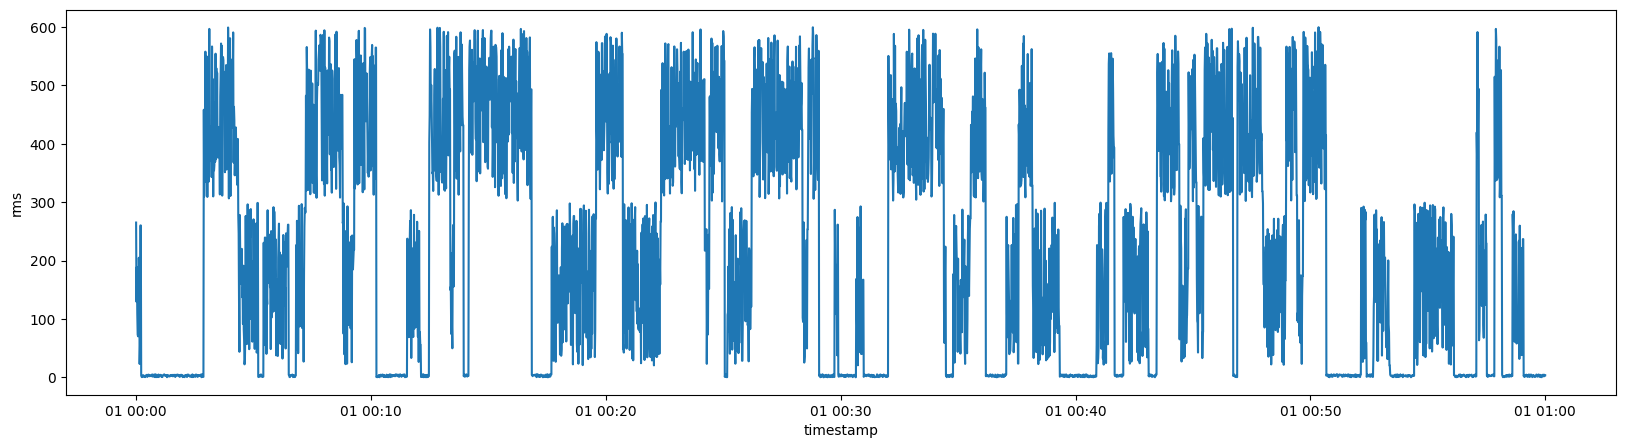

In [ ]:
ax, fig = plt.subplots(figsize=(20, 5))
sns.lineplot(x='timestamp', y='rms', data=df, ax=fig)
plt.show()

In [ ]:
# Create a Kalman Filter
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=0,
                  initial_state_covariance=1,
                  observation_covariance=0.7,
                  transition_covariance=1)

# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(df['rms'].values)
state_means = pd.Series(state_means.flatten(), index=df.index)

# Add the smoothed values to the DataFrame
df['rms_smoothed'] = state_means

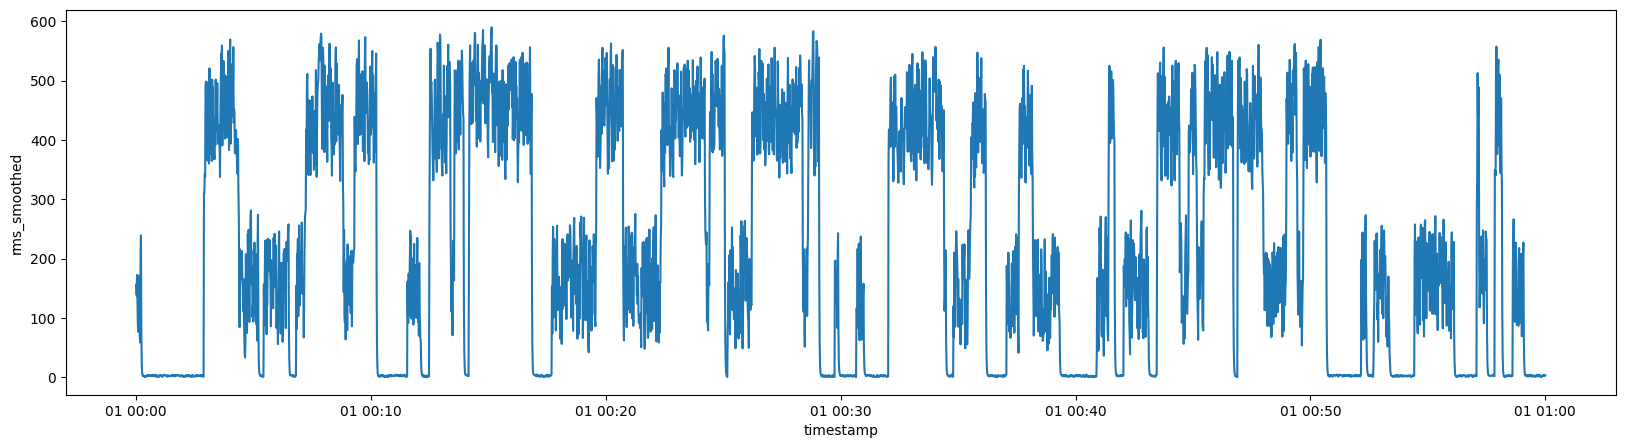

In [ ]:
ax, fig = plt.subplots(figsize=(20, 5))
sns.lineplot(x='timestamp', y='rms_smoothed', data=df, ax=fig)
plt.show()

In [ ]:


# while current_time < end_date:
#     current_state = random.choice(STATES)

#     numbers_only = re.findall(r'\d+', freq)
#     numbers_only = int(numbers_only[0])

#     min_duration = min_duration // numbers_only
#     max_duration = max_duration // numbers_only

#     interval = random.randint(min_duration, max_duration)
#     interval = interval * numbers_only

#     if current_time + timedelta(seconds=interval) > end_date:
#         interval = (end_date - current_time + timedelta(seconds=1)).seconds

#     for _ in range(interval-1):
#         current_rms = random.uniform(0, 5) if current_state == 'OFF' else (random.uniform(20, 300) if current_state == 'IDLE' else random.uniform(301, 600))
#         rms_values.append(current_rms)
#         states.append(current_state)

#     state_end_time = current_time + timedelta(seconds=interval)

#     final_state.append([current_state for i in range(interval)])

#     rms_values.append(current_rms)

#     current_time = state_end_time

# states = [item for sublist in final_state for item in sublist]
# df['state'] = states
# df['rms'] = rms_values